**Imports and initial setup**

In [1]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 26.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=1544da86f6eef762e984a2da87677fcafbbe1b183236571a6e2eabebcffb9f05
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [2]:
!pip install --upgrade spacy

     |████████████████████████████████| 6.0 MB 6.9 MB/s 
     |████████████████████████████████| 457 kB 42.5 MB/s 
     |████████████████████████████████| 181 kB 52.8 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 653 kB 47.8 MB/s 
     |████████████████████████████████| 10.1 MB 37.9 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.

In [3]:
!pip install spacytextblob
!python -m textblob.download_corpora
!python -m spacy download en_core_web_sm

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
     |████████████████████████████████| 13.9 MB 17.0 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
Y

In [4]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 60.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [5]:
import pandas as pd
import nltk
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string, strip_multiple_whitespaces, strip_tags, strip_punctuation, remove_stopwords
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.models import TfidfModel
from gensim.models.phrases import Phraser

import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt

import spacy

import warnings
warnings.filterwarnings('ignore')

# MOVIE_FILE = "IMDb_TLJ_Reviews.csv"
MOVIE_FILE = "IMDb_TMR_Reviews.csv"
NEGATIVE_THRESHOLD = 4.0

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


**Preparing negative review data**

In [6]:
df = pd.read_csv(MOVIE_FILE, index_col=0)
print(df.tail())
print(df.info())

                                                Reviews  Scores
5260  This is what I really feel after watching the ...     7.0
5261  In the first half hour where we find Neo reins...     5.0
5262  It's generally a good movie. I enjoyed watchin...     7.0
5263  Machines, guns, fight scenes and action were a...     2.0
5264  I don't think it's as bad as said. At least a ...     7.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5265 entries, 0 to 5264
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Reviews  5265 non-null   object 
 1   Scores   5199 non-null   float64
dtypes: float64(1), object(1)
memory usage: 123.4+ KB
None


In [7]:
# extracting negative reviews from dataset
df_neg = df[df['Scores'] <= NEGATIVE_THRESHOLD]
print(df_neg.tail())
print(df_neg.info())

# collecting all reviews in a list

data = df.Reviews.values.tolist()
# data = df_neg.Reviews.values.tolist() 


                                                Reviews  Scores
5250  This is the movie where "Matrix" franchise put...     2.0
5254  I cannot believe that people will fall for thi...     2.0
5258  In no way can I avoid the cliché by beginning ...     3.0
5259  This movie was dedicated to such sheep only, a...     1.0
5263  Machines, guns, fight scenes and action were a...     2.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2901 entries, 0 to 5263
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Reviews  2901 non-null   object 
 1   Scores   2901 non-null   float64
dtypes: float64(1), object(1)
memory usage: 68.0+ KB
None


In [14]:
from re import IGNORECASE
# preprocessing review data
N_GRAM_THRESHOLD = 30
CUSTOM_FILTERS = [lambda x: x.lower(), strip_punctuation, remove_stopwords, strip_multiple_whitespaces]
ALLOWED_POSTAGS = ['NOUN', 'ADJ',] # 'VERB', 'ADV'
IGNORE_WORDS = ["movie", "matrix", "t", "film", "thing"]

pdata = [preprocess_string(str(review), filters=CUSTOM_FILTERS) for review in data] # https://radimrehurek.com/gensim/parsing/preprocessing.html

# sample result
print(f"Raw: {data[0]}")
print(f"Preprocessed: {pdata[0]}")

bigram = Phrases(pdata, min_count=3, threshold=N_GRAM_THRESHOLD) 
trigram = Phrases(bigram[pdata], threshold=N_GRAM_THRESHOLD)  

# export bigram and trigram models. They cannot be updated after this step
bigram_model = Phraser(bigram)
trigram_model = Phraser(trigram)

# sample result
def display_n_gram(review, n=2):
  n_grams = list()

  if n == 2:
    review = bigram_model[review]
  if n == 3:
    review = trigram_model[bigram_model[review]]
    
  for word in review:
    if word.count("_") == n-1:
      n_grams.append(word)
  return n_grams

print(f"Bigram in first review: {display_n_gram(pdata[0], 2)}")
print(f"Trigram in first review: {display_n_gram(pdata[0], 3)}")

pdata_bigrams = [bigram_model[review] for review in pdata]
pdata_trigrams = [trigram_model[bigram_model[review]] for review in pdata]

def lemmatization(texts, allowed_postags):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) # load only the tagger tokenizer
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        tokenized_sent = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        tokenized_sent = [token for token in tokenized_sent if token not in IGNORE_WORDS] 
        texts_out.append(tokenized_sent)
    return texts_out

pdata_lemmatized = lemmatization(pdata_bigrams,allowed_postags=ALLOWED_POSTAGS)
print(f"Lemmatized review: {pdata_lemmatized[0]}")




Raw: Warning Spoilers.First part of the movie, tried to be some kind of self-ironic introspective on the state of movies and even made a direct reference to a Matrix sequel. Now the problem with that kind of commentary is that you effectively break the 4th wall or ruin any idea that this isn't just a movie.The film then stumbles towards some kind of plot about the new matrix and Neo/Trinity but fails miserably.The ending is a bore fest of mindless dark action (I mean filmed in the dark) with no tension or point.Did they have a budget of 10m and a timeline of a week to make this film, it certainly looks like it.The original Matrix, in my opinion, is the best film ever made. It has perfect pacing, actions, beautifully realised, cool conversations, properly filmed and choreographed action scenes and even manages a philosophical theme, with all that going on. There is tension, people may and do die, there is a purpose to what they want to achieve. It had a serious tone. It established a se

In [15]:
len(pdata_lemmatized)

5265

**Topic Modelling: LDA with BOW**

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(pdata_lemmatized) # word to ID mapping

# Term Document Frequency - Bag of words
corpus = [id2word.doc2bow(review) for review in pdata_lemmatized] #  list of (token_id, token_count)

print("Bag of words for first review:")
for token_id, token_count in corpus[0]:
  print(f"{id2word[token_id]}: {token_count}")

Bag of words for first review:
4th_wall: 1
ability: 1
acting: 1
action: 2
actual: 1
amateurish: 1
awful: 1
bad: 1
bore: 1
budget: 1
care: 1
character: 1
cheap: 1
childish: 1
choreographed: 1
comment: 1
commentary: 1
conversation: 1
cool: 1
crucial: 1
dark: 2
dialog: 1
direct: 1
f: 1
filmed: 1
footage: 2
game: 1
genuine: 1
good: 1
idea: 1
introspective: 1
ironic: 1
japanese: 1
kind: 1
m: 1
mean: 1
meaningless: 1
mindless: 1
neo_trinity: 1
new: 1
odd: 1
opinion: 1
original: 2
pacing: 1
people: 1
perfect: 1
philosophical: 1
point: 1
power: 1
problem: 1
purpose: 1
reaction: 1
real: 1
reason: 1
reference: 1
ruin: 1
rule: 1
sacrilege: 1
self: 1
sequel: 2
spoiler: 1
state: 1
stumble: 1
super: 1
suspect: 1
tension: 3
terrible: 2
theme: 1
timeline: 1
tone: 1
type: 1
week: 1


**Frequency distribution of tokens in all reviews**

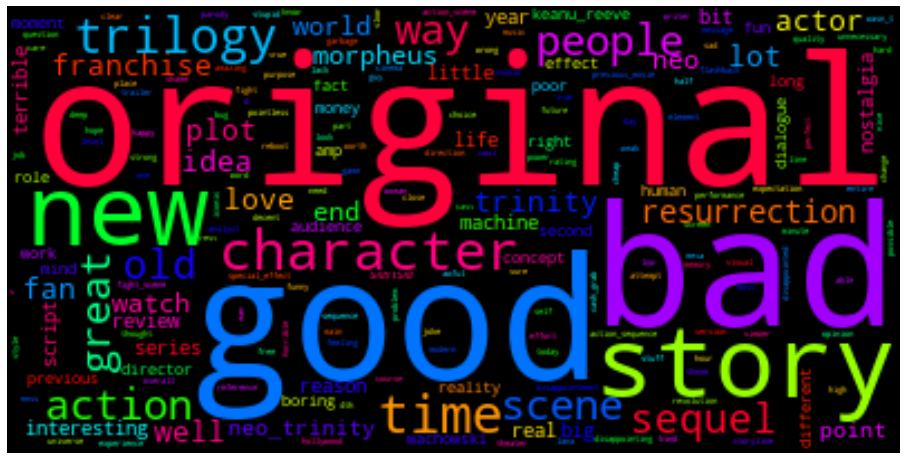

In [17]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_words = [item for sublist in pdata_lemmatized for item in sublist]
dictionary=Counter(all_words)
cloud = WordCloud(max_font_size=80,colormap="hsv").generate_from_frequencies(dictionary)
plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Train LDA Model**

In [18]:
lda_model_bow = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           update_every=1,
                                           chunksize=1000,
                                            passes=100,
                                            iterations=20)
                                          #  passes=10
                                          #  alpha='auto',
                                          #  per_word_topics=True)

In [19]:
print(lda_model_bow.print_topics())
# Compute Perplexity
print('\nPerplexity: ', lda_model_bow.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_bow, texts=pdata_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0, '0.066*"bad" + 0.012*"story" + 0.012*"good" + 0.011*"trilogy" + 0.011*"fan" + 0.010*"time" + 0.010*"terrible" + 0.009*"people" + 0.009*"review" + 0.009*"joke"'), (1, '0.007*"audience" + 0.006*"machine" + 0.006*"studio" + 0.005*"dark" + 0.005*"step" + 0.004*"large" + 0.004*"danger" + 0.004*"black" + 0.003*"light" + 0.003*"scene"'), (2, '0.027*"trinity" + 0.023*"machine" + 0.020*"new" + 0.016*"neo" + 0.016*"human" + 0.015*"world" + 0.015*"power" + 0.015*"people" + 0.011*"life" + 0.010*"neo_trinity"'), (3, '0.020*"resurrection" + 0.009*"franchise" + 0.007*"time" + 0.006*"interesting" + 0.006*"way" + 0.006*"lana" + 0.005*"trilogy" + 0.005*"fourth" + 0.005*"wachowski" + 0.005*"question"'), (4, '0.043*"bad" + 0.021*"good" + 0.012*"money" + 0.011*"watch" + 0.010*"original" + 0.010*"horrible" + 0.009*"poor" + 0.009*"terrible" + 0.009*"hour" + 0.009*"garbage"'), (5, '0.033*"original" + 0.027*"story" + 0.026*"good" + 0.025*"new" + 0.021*"character" + 0.017*"trilogy" + 0.015*"time" + 0.013*"

In [20]:
# BOW on Shawshank Redemption 20 topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_bow, corpus, id2word)
pyLDAvis.save_html(vis, 'lda_tmr_bow_8_topics.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.269640 -0.043600       1        1  53.106553
2      0.048312 -0.287921       2        1  12.357303
0      0.149546  0.129403       3        1  10.143517
3      0.016036 -0.039709       4        1  10.074626
4      0.135202  0.165376       5        1   7.776612
1     -0.211323 -0.021517       6        1   4.686114
7     -0.209925  0.048840       7        1   0.974115
6     -0.197488  0.049128       8        1   0.881161, topic_info=              Term         Freq        Total Category  logprob  loglift
7              bad  2188.000000  2188.000000  Default  30.0000  30.0000
28            good  2505.000000  2505.000000  Default  29.0000  29.0000
42        original  2792.000000  2792.000000  Default  28.0000  28.0000
39             new  2395.000000  2395.000000  Default  27.0000  27.0000
157        trinity   777.000000   777.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
8             bore     5.130059     9.562059   Topic8  -5.5705   4.1090
771        shallow     5.075681    39.461978   Topic8  -5.5811   2.6808
2079        regret     4.042169    16.100933   Topic8  -5.8088   3.3496
1293       picture     4.266804    32.426667   Topic8  -5.7547   2.7036
77    embarrassing     3.753275    13.230974   Topic8  -5.8830   3.4718

[500 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
159       3  0.950450   20_year
6046      5  0.940049      7_10
1         2  0.914949   ability
1         6  0.071761   ability
386       4  0.244858  absolute
...     ...       ...       ...
3943      8  0.941513      yike
1169      1  0.228866      zion
1169      2  0.762887      zion
350       5  0.501493    zombie
350       6  0.480598    zombie

[756 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 1, 4, 5, 2, 8, 7])

**LDA with TFIDF**

In [21]:
tfidf_model = TfidfModel(corpus, normalize=True)

In [22]:
tfidf_corpus = [tfidf_model[corpus[i]] for i in range(len(corpus))]

In [24]:
max_topic = 8 # 8 was the number we got after experimentation
lda_model_tfidf = gensim.models.ldamodel.LdaModel(corpus=tfidf_corpus,
                                           id2word=id2word,
                                           num_topics=max_topic, 
                                           update_every=1,
                                           chunksize=1000,
                                           passes=100,
                                           iterations=20)

In [25]:
# TFIDF model on all reviews dataset
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_tfidf, tfidf_corpus, id2word)
pyLDAvis.save_html(vis, 'lda_tmr_tfidf_8_topics.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.330627  0.016248       1        1  60.213315
7      0.110843  0.149267       2        1  11.619825
2      0.087086 -0.111164       3        1   9.025441
4      0.030495 -0.013455       4        1   4.171502
5      0.029847 -0.015412       5        1   4.129741
1      0.025500 -0.010930       6        1   3.699530
3      0.024591 -0.008154       7        1   3.669251
6      0.022265 -0.006400       8        1   3.471394, topic_info=              Term        Freq       Total Category  logprob  loglift
7              bad  107.000000  107.000000  Default  30.0000  30.0000
42        original  106.000000  106.000000  Default  29.0000  29.0000
28            good  102.000000  102.000000  Default  28.0000  28.0000
92           story   97.000000   97.000000  Default  27.0000  27.0000
39             new   92.000000   92.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
1573       cynical    1.092617    1.579268   Topic8  -6.5476   2.9922
4993  inconsistent    1.073269    1.558030   Topic8  -6.5655   2.9879
2177      likeable    1.051343    1.537014   Topic8  -6.5861   2.9808
1279          hide    1.043384    1.530226   Topic8  -6.5937   2.9777
2047        fanboy    1.194989    1.921385   Topic8  -6.4581   2.8857

[314 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
5771      5  0.948844  150_character
841       2  0.839469    abomination
1569      7  0.555326         absent
3         1  0.997226         action
405       1  0.993723          actor
...     ...       ...            ...
1447      6  0.548971     worthwhile
649       2  0.122971       wouldn_t
649       3  0.737824       wouldn_t
649       6  0.122971       wouldn_t
3943      6  0.551389           yike

[320 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 3, 5, 6, 2, 4, 7])

In [27]:
print(lda_model_tfidf.print_topics())
# Compute Perplexity
print('\nPerplexity: ', lda_model_tfidf.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=pdata_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0, '0.008*"bad" + 0.008*"original" + 0.008*"good" + 0.007*"story" + 0.007*"new" + 0.006*"trilogy" + 0.006*"character" + 0.006*"great" + 0.006*"time" + 0.005*"action"'), (1, '0.004*"seeing" + 0.004*"month" + 0.003*"disgusting" + 0.003*"filme" + 0.003*"cult" + 0.002*"unwatchable" + 0.002*"dvd" + 0.002*"normal" + 0.002*"flash_back" + 0.002*"favour"'), (2, '0.004*"die_hard" + 0.003*"fighting" + 0.003*"night" + 0.003*"story_line" + 0.003*"wouldn_t" + 0.003*"risk" + 0.003*"result" + 0.003*"cheesy" + 0.003*"recommend" + 0.003*"drama"'), (3, '0.005*"confusion" + 0.003*"par" + 0.003*"post" + 0.003*"equal" + 0.003*"sequal" + 0.003*"upset" + 0.002*"evening" + 0.002*"perfection" + 0.002*"adventure" + 0.002*"edition"'), (4, '0.008*"beautiful" + 0.003*"connected" + 0.003*"metaphor" + 0.003*"intense" + 0.003*"understanding" + 0.003*"exist" + 0.003*"fix" + 0.003*"period" + 0.002*"individual" + 0.002*"parallel"'), (5, '0.006*"negative" + 0.004*"disappoint" + 0.004*"disgrace" + 0.003*"150_character" +